In [1]:
from datetime import timedelta
import math
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from stable_baselines3.sac import SAC
from citylearn.agents.rbc import BasicRBC
from citylearn.citylearn import CityLearnEnv
from citylearn.reward_function import CustomEVReward
from citylearn.wrappers import NormalizedObservationWrapper, StableBaselines3Wrapper

In [2]:
schema = 'ev_test_data/citylearn_challenge_2023_phase_2/schema.json'
model_path = 'Results/Shared_PV/sharedpv.zip'

In [3]:
# SAC
env = CityLearnEnv(schema, central_agent=True, reward_function=CustomEVReward)
env = NormalizedObservationWrapper(env)
env = StableBaselines3Wrapper(env)
custom_objects = {
    'lr_schedule': lambda x: .003,
}
model = SAC.load(model_path, custom_objects=custom_objects)

observations = env.reset()
actions_list = []
rewards_list = []

while not env.done:
    actions, _ = model.predict(observations, deterministic=True)
    observations, rewards, _, _ = env.step(actions)
    actions_list.append(actions)
    rewards_list.append(rewards)

display(env.evaluate())

/Users/kingsleyenweye/Desktop/INTELLIGENT_ENVIRONMENT_LAB/CityLearn-EVModel-Parisa/env/lib/python3.7/site-packages/numpy/core/fromnumeric.py:86: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


,cost_function,value,name,level
0,annual_peak_average,1.015742,District,district
1,carbon_emissions_total,0.993714,District,district
2,cost_total,0.985786,District,district
3,daily_peak_average,1.014228,District,district
4,discomfort_delta_average,0.000000,District,district
...,...,...,...,...
79,discomfort_too_cold_proportion,NaN,Building_7,building
80,discomfort_too_hot_proportion,NaN,Building_7,building
81,discomfort_delta_minimum,0.000000,Building_7,building
82,discomfort_delta_maximum,0.000000,Building_7,building


In [4]:
# RBC
rbc_env = CityLearnEnv(schema)
rbc_model = BasicRBC(rbc_env)
rbc_model.learn(episodes=1)
display(rbc_env.evaluate())

/Users/kingsleyenweye/Desktop/INTELLIGENT_ENVIRONMENT_LAB/CityLearn-EVModel-Parisa/env/lib/python3.7/site-packages/numpy/core/fromnumeric.py:86: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


,cost_function,value,name,level
0,annual_peak_average,0.989005,District,district
1,carbon_emissions_total,1.008504,District,district
2,cost_total,1.019578,District,district
3,daily_peak_average,1.171252,District,district
4,discomfort_delta_average,0.000000,District,district
...,...,...,...,...
79,discomfort_too_cold_proportion,NaN,Building_7,building
80,discomfort_too_hot_proportion,NaN,Building_7,building
81,discomfort_delta_minimum,0.000000,Building_7,building
82,discomfort_delta_maximum,0.000000,Building_7,building


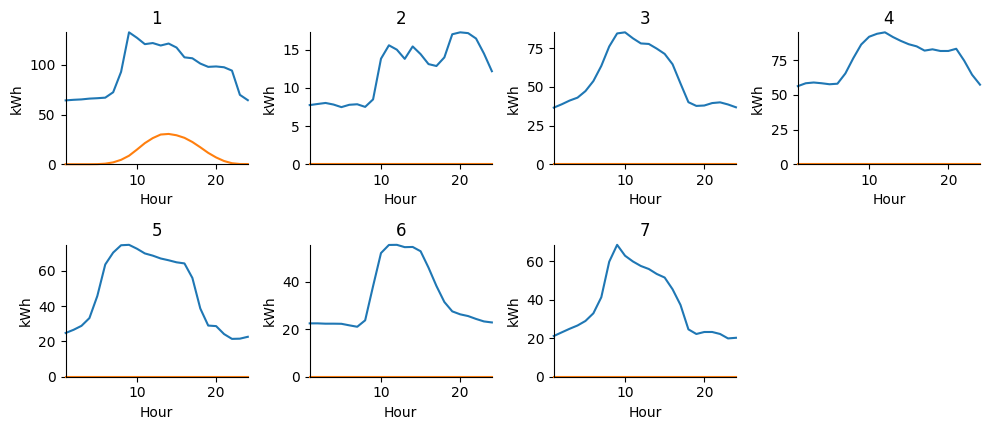

In [5]:
# Average daily profile
building_count = len(env.buildings)
column_count_limit = 4
row_count = math.ceil(building_count/column_count_limit)
column_count = min(column_count_limit, building_count)
fig, _ = plt.subplots(row_count, column_count, figsize=(2.5*column_count, 2.2*row_count))

for ax in fig.axes[building_count:]:
    fig.delaxes(ax)

for i, (ax, b) in enumerate(zip(fig.axes, env.buildings)):
    data = pd.DataFrame({
        'load': b.energy_simulation.non_shiftable_load,
        'generation': abs(b.solar_generation),
        'hour': b.energy_simulation.hour
    })
    data['day_index'] = (data.index/24).astype(int)
    data = data.groupby('hour')[['load', 'generation']].mean()
    x = data.index
    y1 = data['load']
    y2 = data['generation']
    ax.plot(x, y1, color='tab:blue', label='load', clip_on=False)
    ax.plot(x, y2, color='tab:orange', label='generation', clip_on=False)
    ax.set_title(i + 1)
    ax.margins(0)
    ax.set_xlabel('Hour')
    ax.set_ylabel('kWh')

    for s in ['right','top']:
        ax.spines[s].set_visible(False)

plt.tight_layout()
plt.show()

/Users/kingsleyenweye/Desktop/INTELLIGENT_ENVIRONMENT_LAB/CityLearn-EVModel-Parisa/env/lib/python3.7/site-packages/numpy/core/fromnumeric.py:86: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/Users/kingsleyenweye/Desktop/INTELLIGENT_ENVIRONMENT_LAB/CityLearn-EVModel-Parisa/env/lib/python3.7/site-packages/numpy/core/fromnumeric.py:86: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/Users/kingsleyenweye/Desktop/INTELLIGENT_ENVIRONMENT_LAB/Ci

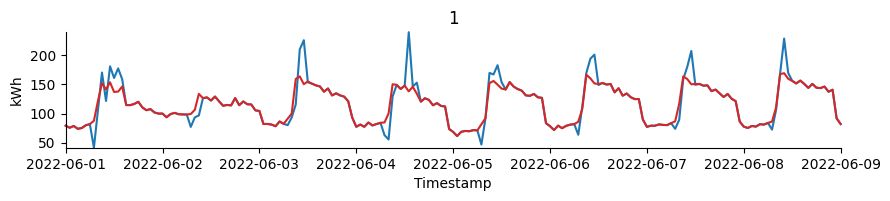

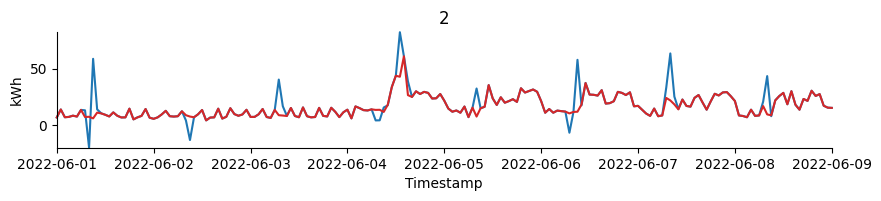

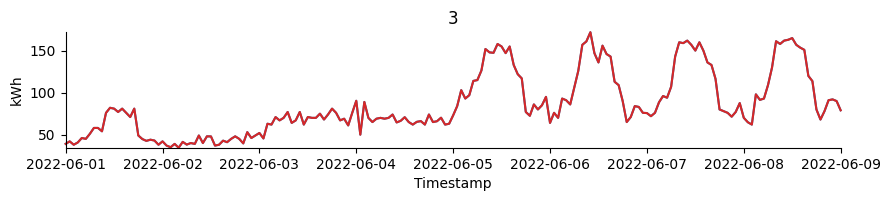

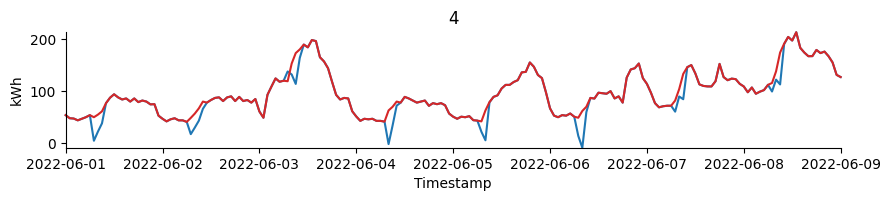

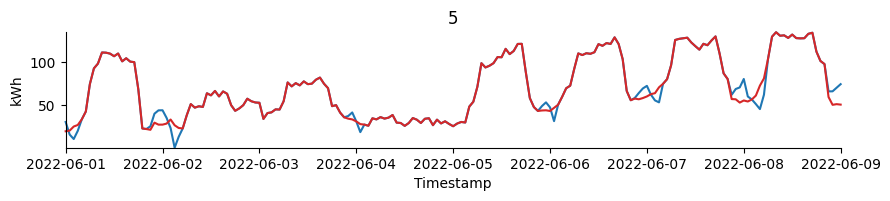

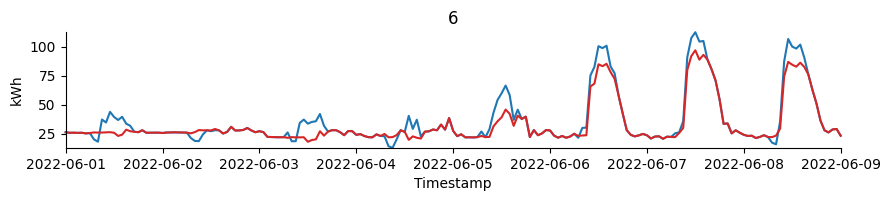

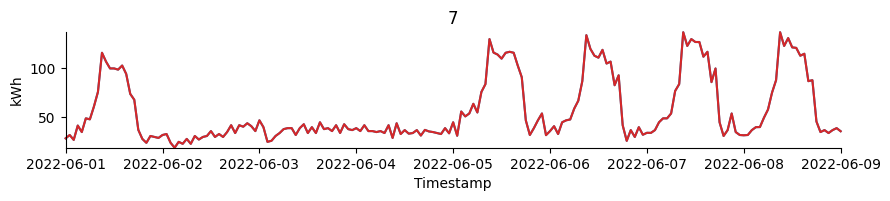

In [6]:
# Profile snapshot
start_timestamp = pd.to_datetime('2022-06-01')
end_timestamp = start_timestamp + timedelta(days=8)
date_range = pd.date_range('2022-01-01', '2022-12-31 23:00:00', freq='H')

for i, b in enumerate(env.buildings):
    data = pd.DataFrame({
        'with_storage': b.net_electricity_consumption,
        'without_storage': b.net_electricity_consumption_without_storage,
        'timestamp': date_range
    })
    data = data[(data['timestamp']>=start_timestamp) & (data['timestamp']<=end_timestamp)]
    x = data['timestamp'].tolist()
    y1 = data['with_storage'].tolist()
    y2 = data['without_storage'].tolist()
    fig, ax = plt.subplots(1, 1, figsize=(10, 1.5))
    ax.plot(x, y1, color='tab:blue', clip_on=False, label='with storage')
    ax.plot(x, y2, color='tab:red', clip_on=False, label='without storage')
    ax.set_title(i + 1)
    ax.set_xlabel('Timestamp')
    ax.set_ylabel('kWh')
    ax.margins(0)

    for s in ['right','top']:
        ax.spines[s].set_visible(False)

/Users/kingsleyenweye/Desktop/INTELLIGENT_ENVIRONMENT_LAB/CityLearn-EVModel-Parisa/env/lib/python3.7/site-packages/numpy/core/fromnumeric.py:86: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


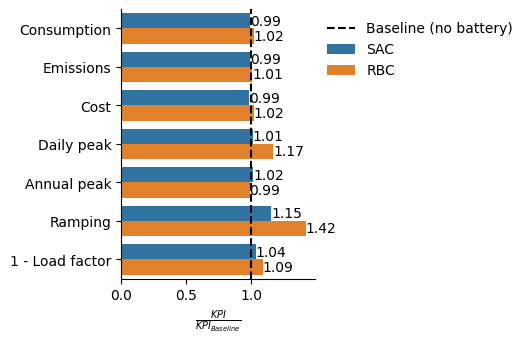

In [7]:
# District level KPI
sac_data = env.evaluate()
rbc_data = rbc_env.evaluate()
sac_data['agent'] = 'SAC'
rbc_data['agent'] = 'RBC'
cost_functions = {
    'electricity_consumption_total': 'Consumption',
    'carbon_emissions_total': 'Emissions',
    'cost_total': 'Cost',
    'daily_peak_average': 'Daily peak',
    'annual_peak_average': 'Annual peak',
    'ramping_average': 'Ramping',
    'one_minus_load_factor_average': '1 - Load factor',
}
data = pd.concat([sac_data, rbc_data], ignore_index=True)
data = data[(data['level']=='district') & (data['cost_function'].isin(cost_functions.keys()))].copy()
data['label'] = data['cost_function'].map(lambda x: cost_functions[x])


fig, ax = plt.subplots(1, 1, figsize=(2.5, 3.5))
hue_order = ['SAC', 'RBC']
sns.barplot(x='value', y='label', data=data, hue='agent', order=cost_functions.values(), hue_order=hue_order, ax=ax)
ax.axvline(1.0, color='black', linestyle='--', label='Baseline (no battery)')
ax.set_xlabel(r'$\frac{KPI}{KPI_{Baseline}}$')
ax.set_ylabel(None)

for s in ['right','top']:
    ax.spines[s].set_visible(False)

for p in ax.patches:
    ax.text(p.get_x() + p.get_width(), p.get_y() + p.get_height()/2.0, f'{p.get_width():0.2f}', ha='left', va='center')
ax.legend(
    bbox_to_anchor=(1.0,1.0),
    loc='upper left',
    framealpha=0,
    ncol=1
)

plt.show()